In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 플레이년도 필터링
df1 = df1[df1['플레이년도'] > 2015]

# 제외할 컬럼 
cols_to_drop = ['선수명_수정'] + ['FA 계약 총액'] + ['연봉']
df1 = df1.drop(columns=cols_to_drop, errors='ignore')

# 해외, FA 1년차 제거
remove_condition = (
    df1['구분'].isin(['해외', 'FA 1년차']) |
    df1['FA등급'].isin(['해외', 'FA 1년차'])
)
df1 = df1[~remove_condition].copy()

In [5]:
# 선수명 기준 평균값으로 그룹핑
df_grouped = df1.groupby('선수명').mean(numeric_only=True).reset_index()
df_grouped2 = df2.groupby('선수명').mean(numeric_only=True).reset_index()

In [6]:
# 상관계수 기반 가중치 계산
numeric_df1 = df1.select_dtypes(include=['number'])  # 계약금 포함
corr = numeric_df1.corr()

target_corr = corr['계약금'].drop('계약금')  # 계약금 제외
sorted_corr = target_corr.abs().sort_values(ascending=False)
weights = sorted_corr / sorted_corr.sum()  # 정규화 가중치

weight_df = weights.reset_index()
weight_df.columns = ['컬럼명', '상관계수 기반 가중치']


C:\Users\Lee\AppData\Local\Temp\ipykernel_25872\3622813656.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights.loc[top_features], y=top_features, palette='Blues_d')


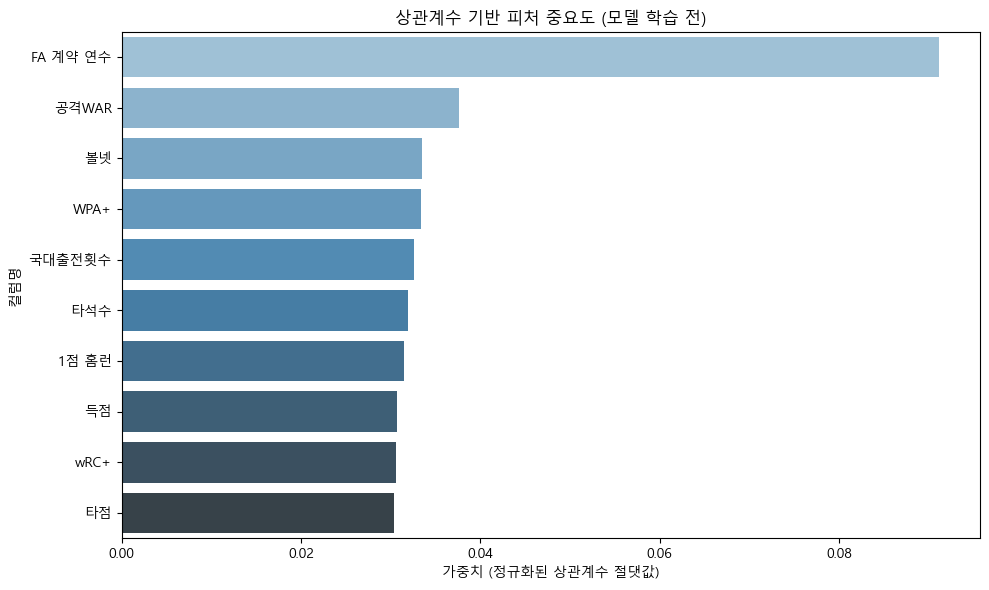

상관계수 기반 피처 중요도:
        컬럼명  상관계수 기반 가중치
0  FA 계약 연수     0.091139
1     공격WAR     0.037665
2        볼넷     0.033546
3      WPA+     0.033367
4    국대출전횟수     0.032578
5       타석수     0.031902
6     1점 홈런     0.031536
7        득점     0.030752
8      wRC+     0.030643
9        타점     0.030418


In [7]:
# 시각화 한글 폰트 설정 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 피처 중요도 시각화
top_n = 10
top_features = weights.head(top_n).index.tolist()

plt.figure(figsize=(10, 6))
sns.barplot(x=weights.loc[top_features], y=top_features, palette='Blues_d')
plt.title('상관계수 기반 피처 중요도 (모델 학습 전)')
plt.xlabel('가중치 (정규화된 상관계수 절댓값)')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

print("상관계수 기반 피처 중요도:")
print(weight_df[weight_df['컬럼명'].isin(top_features)])


In [8]:
# df2에도 존재하는 공통 피처만 사용
common_features = [col for col in top_features if col in df2.columns]
missing = [col for col in top_features if col not in df2.columns]
if missing:
    print(" df2에 존재하지 않아 제외된 컬럼:", missing)

 df2에 존재하지 않아 제외된 컬럼: ['FA 계약 연수']


In [9]:
# 학습/예측 데이터 준비
X_train = df1[common_features]
y_train = df1['계약금']
X_test = df_grouped2[common_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 학습 및 예측
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)
df_grouped2['계약금'] = model.predict(X_test_scaled)

In [10]:
# 모델 기반 피처 중요도 수치화
importance_df = pd.DataFrame({
    '컬럼명': common_features,
    '중요도 (랜덤포레스트)': model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in common_features]
}).sort_values(by='중요도 (랜덤포레스트)', ascending=False)

print("모델 학습 후 피처 중요도:")
print(importance_df)

모델 학습 후 피처 중요도:
      컬럼명  중요도 (랜덤포레스트)  상관계수 기반 가중치
0   공격WAR      0.198978     0.037665
4     타석수      0.118450     0.031902
1      볼넷      0.116900     0.033546
2    WPA+      0.101806     0.033367
5   1점 홈런      0.095135     0.031536
8      타점      0.094624     0.030418
3  국대출전횟수      0.094340     0.032578
7    wRC+      0.093129     0.030643
6      득점      0.086637     0.030752


C:\Users\Lee\AppData\Local\Temp\ipykernel_25872\4025955537.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='중요도 (랜덤포레스트)', y='컬럼명', data=importance_df, palette='Greens_d')


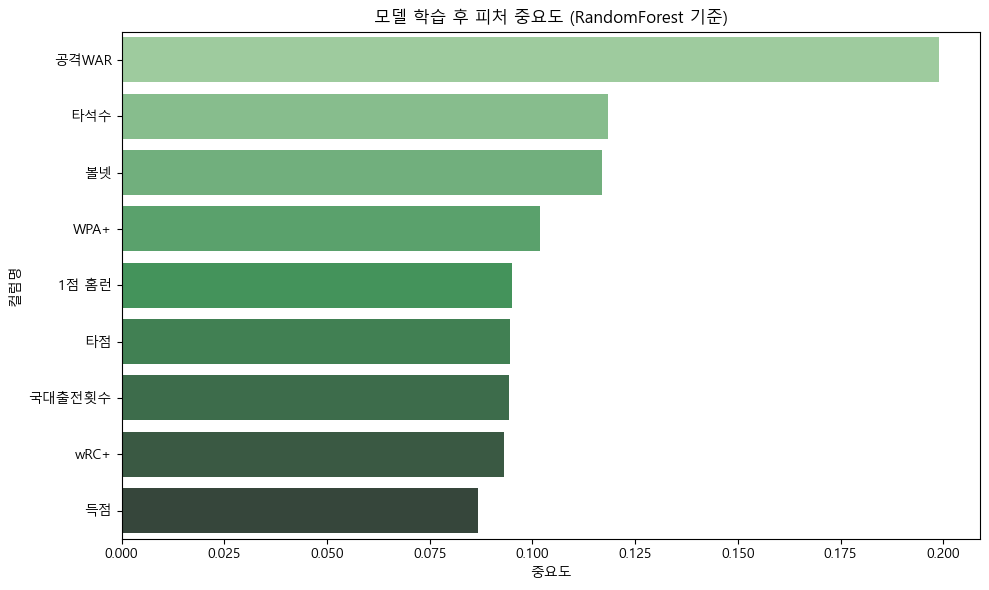

In [11]:
# 모델 기반 피처 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='중요도 (랜덤포레스트)', y='컬럼명', data=importance_df, palette='Greens_d')
plt.title('모델 학습 후 피처 중요도 (RandomForest 기준)')
plt.xlabel('중요도')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [12]:
# 검증 RMSE
X_full = df1[common_features]
y_full = df1['계약금']
X_tr, X_val, y_tr, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

model.fit(X_tr_scaled, y_tr)
val_pred = model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"검증 RMSE: {rmse:,.2f}")

검증 RMSE: 269,044.52


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
print(df_grouped2[['선수명', '계약금']])

    선수명       계약금
0   강민호  334300.0
1   강백호  103434.0
2   김재환  237219.0
3   박병호  258127.0
4   박승욱   36384.0
5   박찬호  349702.0
6   박해민  123607.0
7   손아섭  244550.0
8   이재원   82130.0
9   장성우  307000.0
10   정훈   33466.0
11  조수행   26460.0
12  최원준  115543.0
13  최형우  168063.0
14  황재균  191841.0
